# Introduction



The purpose of this script is to download environmental data associated with changes in krill distribution and abundance from CMIP to support an infographic


https://claut.gitlab.io/man_ccia/lab2.html

Reading around Sea Ice model selection:
https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021GL097413

Explore CMIP products here: https://aims2.llnl.gov/search


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import cartopy.crs as ccrs


# Historical Sea Surface Temperature from CMIP


In [2]:
#If the url is not working, it is best to just download the csv and access it locally
#df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df = pd.read_csv('data/climate/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


**Sea ice concentration**

Use the follwoing document to craft your query (filter the CMIP products): https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q/edit#heading=h.sqoyqmabpjai

In [3]:
df_ta = df.query("variable_id == 'tos' & experiment_id == 'historical' & member_id =='r1i1p1f1' & table_id == 'Omon'")
df_ta.zstore.head()

9976     gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...
9977     gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...
28719    gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...
32357    gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...
43345    gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...
Name: zstore, dtype: object

In [4]:
#access Google Cloud
gcs = gcsfs.GCSFileSystem(token='anon')


In [5]:
# Get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_ta.zstore.values[1]
print(zstore)

gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Omon/tos/gn/v20180701/


In [6]:
# Create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# Open it using xarray and zarr
file1 = xr.open_zarr(mapper, consolidated=True)
ds=file1
file1

<xarray.Dataset>
Dimensions:    (bnds: 2, y: 1080, x: 1440, vertex: 4, time: 1980)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    lat        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lat_bnds   (y, x, vertex) float32 dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
    lon        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lon_bnds   (y, x, vertex) float32 dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * x          (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * y          (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Dimensions without coordinates: vertex
Data variables:
    tos        (time, y, x) float32 dask.array<chunksize=(12, 1080, 1440), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    ...                     ...
    variable_id:            tos
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-08-07;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/9f878dc5-1ff9-4ef2-8f78-6c05e8252599...
    version_id:             v20180701

# Plot the data

In [7]:
import os
import pandas as pd
import requests
from tqdm import tqdm

import netCDF4
from netCDF4 import Dataset,num2date 
import numpy as np
import xarray as xr
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import cmocean

import glob
from datetime import datetime

In [8]:
file1

<xarray.Dataset>
Dimensions:    (bnds: 2, y: 1080, x: 1440, vertex: 4, time: 1980)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    lat        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lat_bnds   (y, x, vertex) float32 dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
    lon        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lon_bnds   (y, x, vertex) float32 dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * x          (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * y          (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Dimensions without coordinates: vertex
Data variables:
    tos        (time, y, x) float32 dask.array<chunksize=(12, 1080, 1440), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    ...                     ...
    variable_id:            tos
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-08-07;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/9f878dc5-1ff9-4ef2-8f78-6c05e8252599...
    version_id:             v20180701

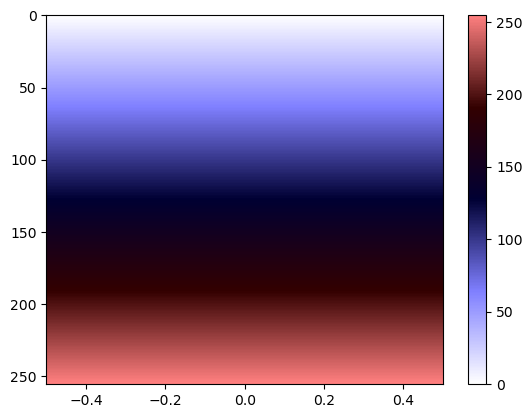

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define the colors in the colormap with white at either end
colors = [(1, 1, 1),    # white
          (0.5, 0.5, 1),  # light blue
          (0, 0, 0.2),    # dark blue
#          (0, 0, 0),       # black
          (0.2, 0, 0),     # dark red
          (1, 0.5, 0.5)]    # light red
                # white

# Create the colormap
diverging_colormap = LinearSegmentedColormap.from_list('diverging_colormap', colors, N=256)

# Plot a colorbar to visualize the colormap
plt.imshow([[i] for i in range(256)], cmap=diverging_colormap, aspect='auto')
plt.colorbar()
plt.show()


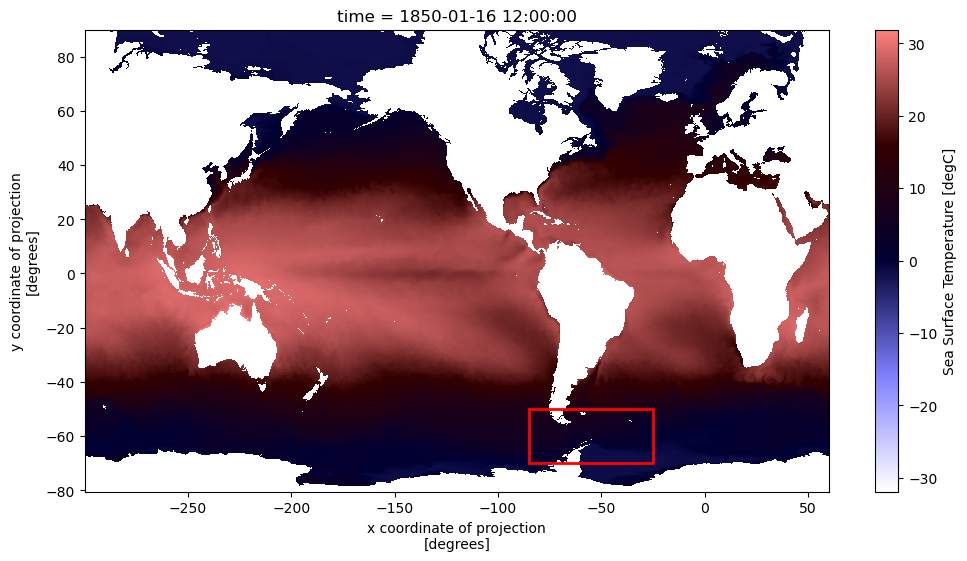

In [10]:
from matplotlib.patches import Rectangle

# Select Variable here
var = file1.tos


#ax.contourf(lons_pi, lats_pi, uo_dif_surf[0,:,:]
from matplotlib import pyplot as plt, animation
from IPython.display import HTML, display

# Get a handle on the figure and the axes
fig, ax = plt.subplots(figsize=(12,6))

# Plot the initial frame. 
cax = var[0,:,:].plot(
    add_colorbar=True,
  # vmin=-340, vmax=340,
    cmap=diverging_colormap,
    cbar_kwargs={
        'extend':'neither'
    }
)

xmin=-85
ymin= -70

# Define the bounding box coordinates (example values, replace them with your actual values)
bbox_coords = [xmin, ymin, 60, 20]  # Adjust these values as needed

# Create a Rectangle patch
bbox_patch = Rectangle(
    (bbox_coords[0], bbox_coords[1]),
    bbox_coords[2],
    bbox_coords[3],
    linewidth=2,
    edgecolor='red',
    facecolor='none',  # Set facecolor to 'none' for a transparent fill
)

# Add the Rectangle patch to the axes
ax.add_patch(bbox_patch)



#Best to downoad the data (if not too large), for speed of plotting etc.
ds.to_netcdf('data/climate/historical_sst_NOAA-GFDL.nc')

In [11]:
ds=xr.open_dataset('data/climate/historical_sst_NOAA-GFDL.nc')
ds = file1.tos.sel( x=slice(-85,-25),y=slice(-70,-50))
ds

<xarray.DataArray 'tos' (time: 1980, y: 163, x: 238)>
dask.array<getitem, shape=(1980, 163, 238), dtype=float32, chunksize=(12, 163, 238), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(163, 238), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(163, 238), meta=np.ndarray>
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * x        (x) float64 -84.87 -84.62 -84.37 -84.11 ... -25.63 -25.38 -25.13
  * y        (y) float64 -69.95 -69.85 -69.75 -69.64 ... -50.38 -50.22 -50.06
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    long_name:      Sea Surface Temperature
    original_name:  tos
    standard_name:  sea_surface_temperature
    units:          degC

<a list of 3 text.Text objects>

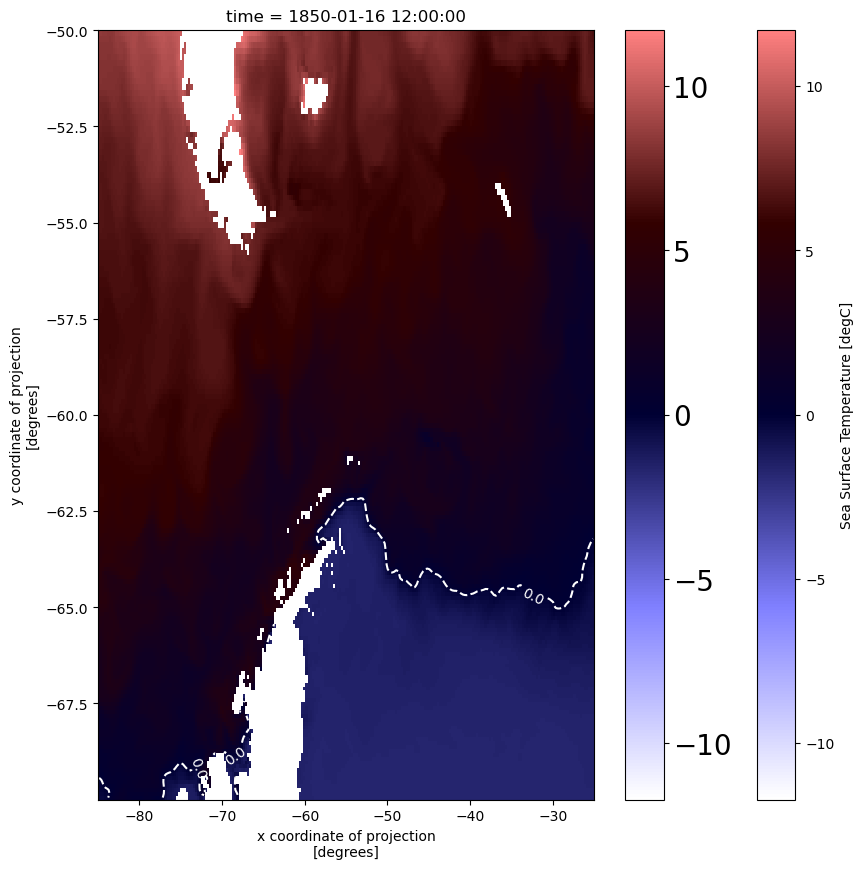

In [12]:

# Select Variable here
var = ds

#ax1.contour(frac_late.lon, frac_late.lat, frac_late, levels=[15], colors='red', linewidths=2, transform=ccrs.PlateCarree())

#ax.contourf(var.lon, var.lat, var, levels=[0], colors='white', linewidths=2, transform=ccrs.PlateCarree())
from matplotlib import pyplot as plt, animation
from IPython.display import HTML, display

# Get a handle on the figure and the axes
fig, ax = plt.subplots(figsize=(10,10))

# Plot the initial frame. 
cax = var[0,:,:].plot(
    #add_colorbar=True,
    cmap=diverging_colormap,
    cbar_kwargs={
        'extend':'neither'
    }
)
# Add white contour line at 0 values
contour = plt.contour(var[0, :, :].x, var[0, :, :].y, var[0, :, :], levels=[0], colors='white', linestyles='dashed')
colorbar = plt.colorbar(cax)
colorbar.ax.tick_params(labelsize=20)  # Adjust the font size as needed

# Optionally, you can add labels to the contour lines
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)


## Calculate by time periods

In [13]:
# Define the time range
start_yr = 1925
end_yr = 1955

# Select the 'summer' months (December, January, February) for each year
sum_early = ds.sel(time=ds['time.month'].isin([12,1,2]) & (ds['time.year'] >= start_yr) & (ds['time.year'] <= end_yr))
sum_early_mean=sum_early.mean(dim='time')

# Select the 'winter' months (June, July, August) for each year
win_early = ds.sel(time=ds['time.month'].isin([6, 7, 8]) & (ds['time.year'] >= start_yr) & (ds['time.year'] <= end_yr))
win_early_mean=win_early.mean(dim='time')

In [14]:
sum_early

<xarray.DataArray 'tos' (time: 93, y: 163, x: 238)>
dask.array<getitem, shape=(93, 163, 238), dtype=float32, chunksize=(3, 163, 238), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(163, 238), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(163, 238), meta=np.ndarray>
  * time     (time) object 1925-01-16 12:00:00 ... 1955-12-16 12:00:00
  * x        (x) float64 -84.87 -84.62 -84.37 -84.11 ... -25.63 -25.38 -25.13
  * y        (y) float64 -69.95 -69.85 -69.75 -69.64 ... -50.38 -50.22 -50.06
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    long_name:      Sea Surface Temperature
    original_name:  tos
    standard_name:  sea_surface_temperature
    units:          degC

In [15]:

# Define the time range
start_yr = 1995
end_yr = 2014

#Select the 'summer' months (December, January, February) for each year
sum_late = ds.sel(time=ds['time.month'].isin( [12,1,2]) & (ds['time.year'] >= start_yr) & (ds['time.year'] <= end_yr))
sum_late_mean=sum_late.mean(dim='time')

# Select the 'winter' months (June, July, August) for each year
win_late = ds.sel(time=ds['time.month'].isin([6, 7, 8]) & (ds['time.year'] >= start_yr) & (ds['time.year'] <= end_yr))
win_late_mean=win_late.mean(dim='time')

In [16]:
# Calculate the average over the selected time range
win_dif = win_early.mean(dim='time')-win_late.mean(dim='time')

# Calculate the average over the selected time range
sum_dif = sum_early.mean(dim='time')-sum_late.mean(dim='time')


## Calculate differences

In [17]:
print(sum_early.mean().compute())

<xarray.DataArray 'tos' ()>
array(2.6728437, dtype=float32)


In [18]:
sum_early.sel(y=slice(-70,-60)).mean().compute()

<xarray.DataArray 'tos' ()>
array(0.84440994, dtype=float32)

In [19]:
sum_early.sel(y=slice(-60,-50)).mean().compute()

<xarray.DataArray 'tos' ()>
array(5.0629554, dtype=float32)

In [20]:
sum_late.sel(y=slice(-60,-50)).mean().compute()

<xarray.DataArray 'tos' ()>
array(5.1375422, dtype=float32)

In [21]:
sum_late.sel(y=slice(-70,-60)).mean().compute()

<xarray.DataArray 'tos' ()>
array(0.9443687, dtype=float32)

## Plot differences

In [22]:
import cartopy.io.shapereader as shpreader
#cst10_polygon.shp is downloaded from https://data.bas.ac.uk/items/98d7c98c-b223-4774-b20e-886630632b12/
fname= 'data/environment/add_coastline_high_res_line_v7_8.shp' 
reader = shpreader.Reader(fname)

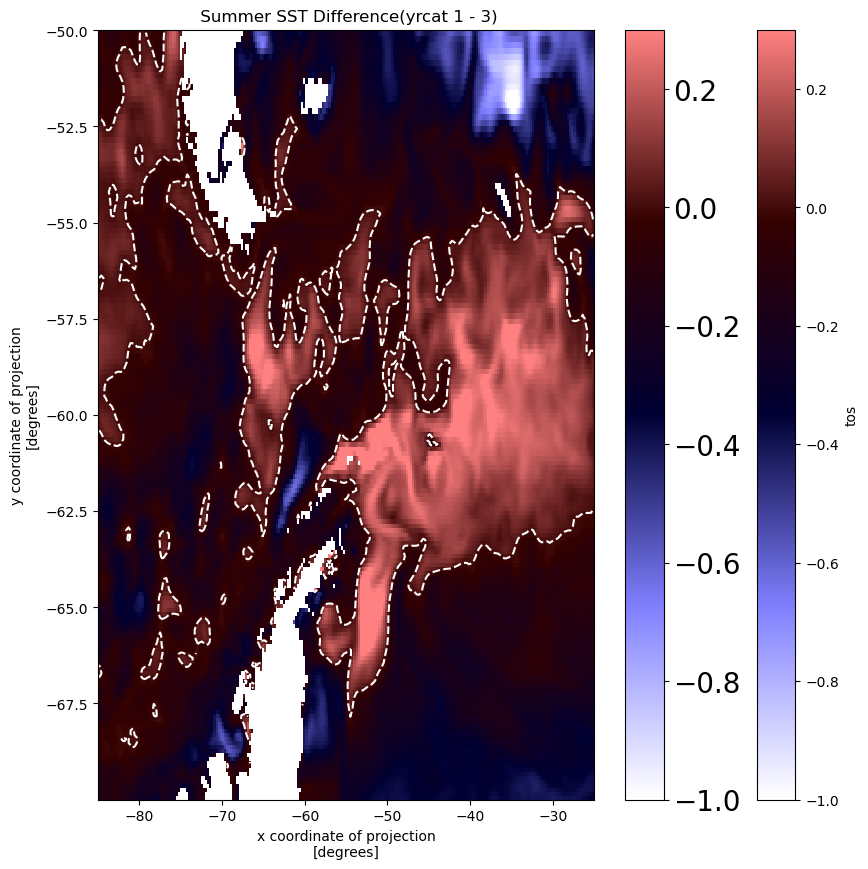

In [23]:
# Select Variable here
var = sum_dif

# Create a mask for NA values
nan_mask = np.isnan(var)

# Get a handle on the figure and the axes
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the initial frame.
cax = var.plot(
    add_colorbar=True,
    cmap=diverging_colormap,
    vmin=-1,
    vmax=0.3,
    cbar_kwargs={
        'extend': 'neither'
    }
)

# Add white contour line at 0 values
contour = plt.contour(var.x, var.y, var, levels=[0], colors='white', linestyles='dashed')


colorbar = plt.colorbar(cax)
colorbar.ax.tick_params(labelsize=20)  # Adjust the font size as needed

# Optionally, you can add labels to the contour lines
# plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)

plt.title(f' Summer SST Difference(yrcat 1 - 3)')
plt.savefig('figures/krillfo_Summer SST Difference(yrcat 1 - 3).png')


In [24]:
sum_dif

<xarray.DataArray 'tos' (y: 163, x: 238)>
dask.array<sub, shape=(163, 238), dtype=float32, chunksize=(163, 238), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(163, 238), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(163, 238), meta=np.ndarray>
  * x        (x) float64 -84.87 -84.62 -84.37 -84.11 ... -25.63 -25.38 -25.13
  * y        (y) float64 -69.95 -69.85 -69.75 -69.64 ... -50.38 -50.22 -50.06

## Write sst differences

In [25]:
import rioxarray
sum_dif.rio.to_raster("output/sst_dif_summer_ycat1-3.tif")